In [1]:
from influxdb import InfluxDBClient
from  credentials import *
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
client = InfluxDBClient(host=host, port=port, username=username, password=password)
client.switch_database('orkney')

__u__: (from west to east) in m/s	
__v__: (from south to north) in m/s

In [3]:
#Get temperature data
Wind = client.query('SELECT * FROM "Wind" WHERE time > now() - 220d ORDER BY time')
values = Wind.raw["series"][0]["values"]
columns = Wind.raw["series"][0]["columns"]
Wind = pd.DataFrame(values, columns=columns)#.set_index("time")
Wind.head(2)
#https://www.cactus2000.de/uk/unit/masswin.shtml

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  
0 -5.120623  
1 -5.522073

In [4]:
Wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       3476 non-null   object 
 1   M/S        3476 non-null   float64
 2   height     3476 non-null   object 
 3   latitude   3476 non-null   object 
 4   longitude  3476 non-null   object 
 5   u          3476 non-null   float64
 6   v          3476 non-null   float64
dtypes: float64(3), object(4)
memory usage: 190.2+ KB


$$
\phi=\bmod \left(180+\frac{180}{\pi} \operatorname{atan} 2(v, u), 360\right)
$$

In [5]:
def find_direction(u,v):
    direction =np.mod(180+np.rad2deg(np.arctan2(u,v)),360)
    return direction
    

In [6]:
Wind['Wind_Direction_deg'] = Wind.apply(lambda x: find_direction(x.u,x.v),axis=1)

In [7]:
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg  
0 -5.120623          335.408490  
1 -5.522073          335.018373

In [8]:
bins = np.linspace(0, 360, 17)+11.25
bins = np.insert(bins, 0, 0)
names = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW', 'N2']
Wind['Wind_Direction'] = pd.cut(Wind['Wind_Direction_deg'], bins, labels=names)
Wind['Wind_Direction'] = Wind['Wind_Direction'].replace('N2', 'N')

In [9]:
#https://community.plotly.com/t/wind-rose-with-wind-speed-m-s-and-direction-deg-data-columns-need-help/33274/7

In [10]:
Wind.head(5)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   
2  2021-08-02T00:00:00Z  5.798643   10.0       59    356.75  3.290276   
3  2021-08-02T00:00:00Z  6.298723   80.0       59    356.75  3.628037   
4  2021-08-02T03:00:00Z  5.008651   10.0       59    356.75  3.384199   

          v  Wind_Direction_deg Wind_Direction  
0 -5.120623          335.408490            NNW  
1 -5.522073          335.018373            NNW  
2 -4.774761          325.429369             NW  
3 -5.148909          324.830611             NW  
4 -3.692395          317.493738             NW

In [11]:
Wind.sum()

<ipython-input-11-4574f0ba2cf3>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Wind.sum()


time                  2021-08-01T21:00:00Z2021-08-01T21:00:00Z2021-0...
M/S                                                        36345.412382
height                10.080.010.080.010.080.010.080.010.080.010.080...
latitude              5959595959595959595959595959595959595959595959...
longitude             356.75356.75356.75356.75356.75356.75356.75356....
u                                                          14706.636471
v                                                           4401.711274
Wind_Direction_deg                                        765165.180226
dtype: object

In [12]:
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction  
0 -5.120623          335.408490            NNW  
1 -5.522073          335.018373            NNW

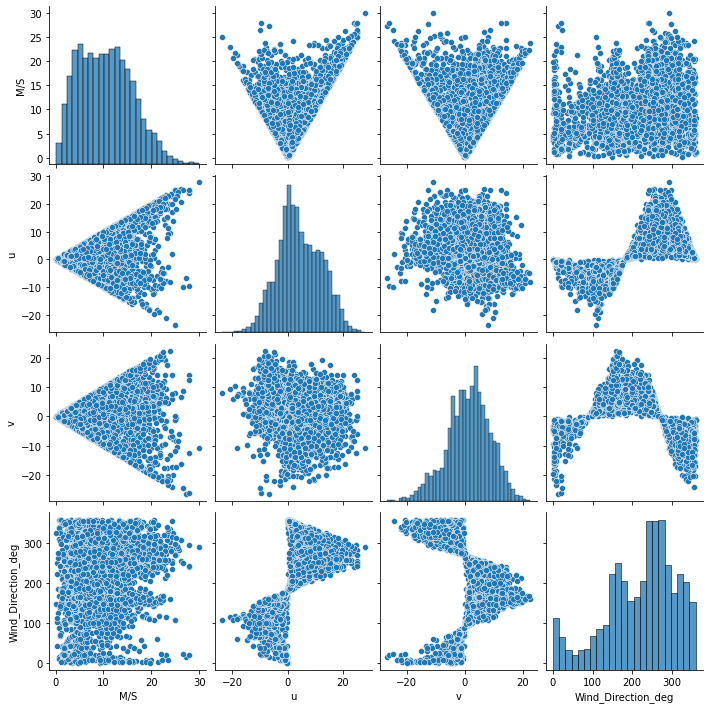

In [13]:
sns.pairplot(Wind)

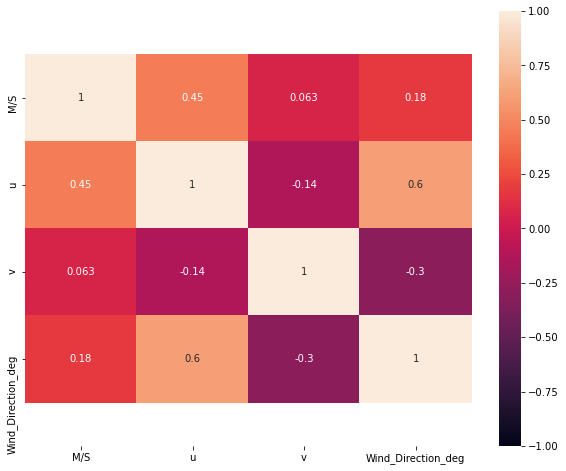

In [14]:
#correlation between the values
corr = Wind.corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('img/heat_map.png')
plt.show()


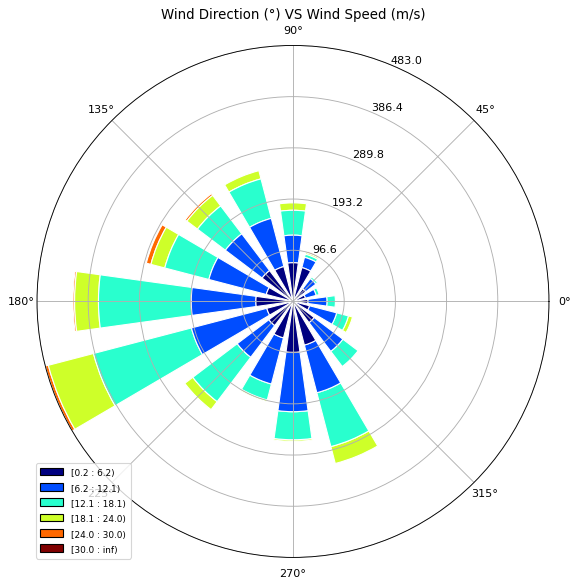

In [15]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(Wind['Wind_Direction_deg'], Wind['M/S'], normed=False, opening=0.7, edgecolor='white')
ax.set_legend()
plt.title("Wind Direction (°) VS Wind Speed (m/s)")
plt.savefig('img/Wind_Direction3.png')
plt.show()

In [16]:
Wind['Datetime'] = pd.to_datetime(Wind.time)


In [17]:
Wind["Year"] = Wind.Datetime.dt.year

In [18]:
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction                  Datetime  Year  
0 -5.120623          335.408490            NNW 2021-08-01 21:00:00+00:00  2021  
1 -5.522073          335.018373            NNW 2021-08-01 21:00:00+00:00  2021

In [19]:
Wind["Month"] = Wind.Datetime.dt.month
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction                  Datetime  \
0 -5.120623          335.408490            NNW 2021-08-01 21:00:00+00:00   
1 -5.522073          335.018373            NNW 2021-08-01 21:00:00+00:00   

   Year  Month  
0  2021      8  
1  2021      8

In [20]:
Wind["day"] = Wind.Datetime.dt.day
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction                  Datetime  \
0 -5.120623          335.408490            NNW 2021-08-01 21:00:00+00:00   
1 -5.522073          335.018373            NNW 2021-08-01 21:00:00+00:00   

   Year  Month  day  
0  2021      8    1  
1  2021      8    1

<AxesSubplot:xlabel='Month'>

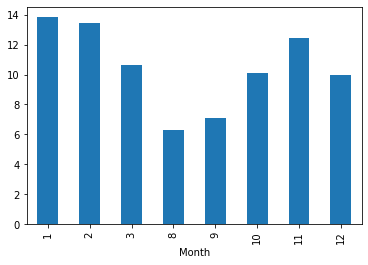

In [21]:
Wind.groupby('Month')['M/S'].mean().plot.bar()

In [22]:
Wind["Hour"] = Wind.Datetime.dt.hour
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction                  Datetime  \
0 -5.120623          335.408490            NNW 2021-08-01 21:00:00+00:00   
1 -5.522073          335.018373            NNW 2021-08-01 21:00:00+00:00   

   Year  Month  day  Hour  
0  2021      8    1    21  
1  2021      8    1    21

In [23]:
Wind["Daily"]=Wind.groupby('day').apply(list)#['b'].apply(list)

In [24]:
Wind.sample(4)

time        M/S height latitude longitude          u  \
124   2021-08-09T15:00:00Z   4.491547   10.0       59    356.75  -0.246941   
3231  2022-02-22T12:00:00Z  19.495928   80.0       59    356.75  19.477446   
2059  2021-12-09T09:00:00Z   7.210964   80.0       59    356.75   6.620862   
338   2021-08-23T00:00:00Z   4.600186   10.0       59    356.75   4.586807   

             v  Wind_Direction_deg Wind_Direction                  Datetime  \
124  -4.484754            3.151656              N 2021-08-09 15:00:00+00:00   
3231 -0.848711          272.495030              W 2022-02-22 12:00:00+00:00   
2059  2.856956          246.659412            WSW 2021-12-09 09:00:00+00:00   
338   0.350596          265.629057              W 2021-08-23 00:00:00+00:00   

      Year  Month  day  Hour Daily  
124   2021      8    9    15   NaN  
3231  2022      2   22    12   NaN  
2059  2021     12    9     9   NaN  
338   2021      8   23     0   NaN

In [25]:
Wind.head(2)

time       M/S height latitude longitude         u  \
0  2021-08-01T21:00:00Z  5.631403   10.0       59    356.75  2.343486   
1  2021-08-01T21:00:00Z  6.092023   80.0       59    356.75  2.572830   

          v  Wind_Direction_deg Wind_Direction                  Datetime  \
0 -5.120623          335.408490            NNW 2021-08-01 21:00:00+00:00   
1 -5.522073          335.018373            NNW 2021-08-01 21:00:00+00:00   

   Year  Month  day  Hour                                              Daily  
0  2021      8    1    21                                                NaN  
1  2021      8    1    21  [time, M/S, height, latitude, longitude, u, v,...

In [26]:
import plotly.express as px
#df = px.data.tips()
fig = px.line(Wind, x="time", y=["M/S"]#, points="all"
             )
fig.show()

In [27]:
#bins = np.linspace(0, 360, 17)+11.25
#bins = np.insert(bins, 0, 0)
#names = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW', 'N2']
#Wind['wind_dir_Range'] = pd.cut(Wind['Wind_Direction'], bins, labels=names)
#Wind['wind_dir_Range'] = Wind['wind_dir_Range'].replace('N2', 'N')

In [33]:
import plotly.express as px
#df = px.data.wind()
fig = px.bar_polar(Wind, r="M/S", #theta="Wind_Direction",
                   color="M/S", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Viridis#px.colors.sequential.Plasma_r
                  )
fig.write_html("img/Wind_Direction1.html")
fig.show()

In [29]:
import plotly.express as px
df = px.data.wind()
fig = px.bar_polar(Wind, r="u", theta="Wind_Direction",
                   color="Wind_Direction", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.write_html("img/Wind_Direction2.html")
fig.show()

In [30]:
df

direction strength  frequency
0           N      0-1        0.5
1         NNE      0-1        0.6
2          NE      0-1        0.5
3         ENE      0-1        0.4
4           E      0-1        0.4
..        ...      ...        ...
123       WSW       6+        0.1
124         W       6+        0.9
125       WNW       6+        2.2
126        NW       6+        1.5
127       NNW       6+        0.2

[128 rows x 3 columns]

In [31]:
#Get temperature data
Temperature = client.query('SELECT * FROM "Temperature" WHERE time > now() - 3d ORDER BY time')
values = Temperature.raw["series"][0]["values"]
columns = Temperature.raw["series"][0]["columns"]
Temperature = pd.DataFrame(values, columns=columns)#.set_index("time")
Temperature.head(10)

time   Celsius latitude longitude
0  2022-03-06T21:00:00Z  7.440515       59    356.75
1  2022-03-07T00:00:00Z  7.203851       59    356.75
2  2022-03-07T03:00:00Z  7.249994       59    356.75
3  2022-03-07T06:00:00Z  7.149988       59    356.75
4  2022-03-07T09:00:00Z  7.149988       59    356.75
5  2022-03-07T12:00:00Z  7.249994       59    356.75
6  2022-03-07T15:00:00Z  7.367761       59    356.75
7  2022-03-07T18:00:00Z  7.324701       59    356.75
8  2022-03-07T21:00:00Z  7.467767       59    356.75
9  2022-03-08T00:00:00Z  7.491754       59    356.75